<a href="https://colab.research.google.com/github/jiayuangu762943/2022-spring-dov-level-ie/blob/main/6_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **6. Model Pruning**

## 6.0 Setup GDrive and Git

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:

# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

%mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
!git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a2-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-{YOUR_HANDLE}"

mkdir: cannot create directory ‘/content/gdrive/MyDrive/ece5545’: File exists
/content/gdrive/MyDrive/ece5545
fatal: destination path 'a2-jiayuangu762943' already exists and is not an empty directory.
/content/gdrive/MyDrive/ece5545/a2-jiayuangu762943
Already on 'main'
Your branch is up to date with 'origin/main'.
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 6 (delta 1), reused 1 (delta 1), pack-reused 4 (from 1)
Unpacking objects: 100% (6/6), 109.93 KiB | 872.00 KiB/s, done.
From https://github.com/ML-HW-SYS/a2-jiayuangu762943
   cf8ffc5..336a889  main       -> origin/main
Updating cf8ffc5..336a889
Fast-forward
 6_pruning.ipynb | 1018 +++++++++++++++++++++++++++++++++++++++++++++++++--------------------------
 1 file changed, 667 insertions(+), 351 deletions(-)
/content/gdrive/MyDrive/ece5545


In [4]:

# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

### GPU: Ensure you are running the GPU runtime type:
1.   Click "Runtime" on top banner
2.   Select "Change runtime type"
3.   Under "Hardware accelarator" select "GPU" and save

### Install required packages

In [5]:
!pip install torchaudio

### Import code dependencies

In [6]:

# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy

import time

import sys

# Adding assignment1 to the system path-- make sure this matches your git directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will
# reproduce the training and testing results
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

Model folders are created, 
PyTorch models will be saved in /content/gdrive/MyDrive/ece5545/models/torch_models, 
ONNX models will be saved in /content/gdrive/MyDrive/ece5545/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/gdrive/MyDrive/ece5545/models/tf_models, 
TensorFlow Lite models will be saved in /content/gdrive/MyDrive/ece5545/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/gdrive/MyDrive/ece5545/models/micro_models.


## 6.1 Prepare for Training



In [7]:
# Create audio_processor
# DATASET_DIR is defined in constants.py
audio_processor = data_proc.AudioProcessor()
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders

from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

>> Downloading speech_commands_v0.02.tar.gz 100.0%
Audio_processor created
Using cpu to run the training scrpit.
Train size: 10556 Val size: 1333 Test size: 1368


TinyConv(
  (conv_reshape): Reshape(output_shape=(-1, 1, 49, 40))
  (conv): Conv2d(1, 8, kernel_size=(10, 8), stride=(2, 2), padding=(5, 3))
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_reshape): Reshape(output_shape=(-1, 4000))
  (fc): Linear(in_features=4000, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [8]:
!ls {TORCH_DIR}

 fp32_checkpoint.pt	      '(QAT4bit)quant_0.pt'   quant_checkpoint.pt
 fp32_finetune_checkpoint.pt  '(QAT6bit)quant_0.pt'   tinyconv_float32_init_seed0_90.20%_0.pt
'(QAT2bit)quant_0.pt'	      '(QAT8bit)quant_0.pt'


### **TODO: Replace the torch_path model with the model you created in the last section.**

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [ ]:
# TODO: Replace me!
torch_path = os.path.join("/content/gdrive/MyDrive/ece5545/models/torch_models/", "tinyconv_float32_init_seed0_90.20%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path, map_location=torch.device('cpu')))
model_fp32_orig = copy.deepcopy(model_fp32)
model_fp32, model_fp32_orig

NameError: name 'copy' is not defined

## 6.2 Structured Pruning

In this section, you will try to conduct structured pruning on the TinyConv model and explore its effect on performance.
In this notebook, you will be only given minimum scarfolding code. Please take advantages of the code in previous section to faciliate.

Following link will be helpful:
[torch.nn.utils.prune.LnStructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.LnStructured.html?highlight=prune#torch.nn.utils.prune.LnStructured.prune)
[Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

### from part 5

In [10]:
from src.train_val_test_utils import train, test

def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device, epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            pbar.update(1)

def accuracy(test_loader, model, device='cpu'):
    model.to(device)
    model.eval()
    num_correct = 0
    total_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)

            start_time = time.time()
            outputs = model(data)
            end_time = time.time()

            batch_time = end_time - start_time
            total_time += batch_time
            total_samples += data.size(0)

            predict = outputs.argmax(dim=-1)
            num_correct += predict.squeeze().eq(label).sum().item()
            print("batch_time", batch_time)
            print("batch_sample", data.size(0))

    model_acc = num_correct / len(test_loader.dataset)
    avg_inference_time = total_time / total_samples
    print(f'Model predicts {model_acc*100:.3f}% of the samples correctly.')
    print(f'Average inference time per sample: {avg_inference_time*1000:.3f} ms.\n')

    return model_acc, avg_inference_time

def count_nonzero_weights(model):
    """
    Counts nonzero weights for modules without pruning wrappers.
    """
    count = 0
    for param in model.parameters():
        count += torch.count_nonzero(param).item()
    return count

### from part 4

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip3 install onnx
!pip3 install tensorflow-addons
!pip3 install tensorflow-probability

!pip3 install torchaudio

# Install onnx-tensorflow
# !git clone https://github.com/onnx/onnx-tensorflow.git
# !cd onnx-tensorflow && pip3 install -e .
!pip3 install onnx-tf==1.9.0
!pip install 'keras<3.0.0'
!pip install tensorflow==2.12.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 42.4 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and

In [ ]:
 # Import libraries
import sys,os
PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a2-jiayuangu762943"
# Add path to onnx-tensorflow
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'onnx-tensorflow'))
sys.path.insert(0, PROJECT_ROOT)

import onnx
import torch
import torch.nn as nn
import numpy as np
import os
import tensorflow as tf
print(f"TensorFlow Version is: {tf.__version__}")
from onnx_tf.backend import prepare

# Import constants to use constants defined for training
from src.constants import *
import src.data_proc as data_proc

TensorFlow Version is: 2.12.0


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

Model folders are created, 
PyTorch models will be saved in /content/models/torch_models, 
ONNX models will be saved in /content/models/onnx_models, 
TensorFlow Saved Models will be saved in /content/models/tf_models, 
TensorFlow Lite models will be saved in /content/models/tflite_models, 
TensorFlow Lite Micro models will be saved in /content/models/micro_models.


In [ ]:
import os
import torch
import numpy as np
import onnx
import tensorflow as tf
from onnx_tf.backend import prepare

def export_model_without_first_last(model):

    new_model = nn.Sequential()
    # Exclude conv_reshape (first layer) and softmax (last layer)
    new_model.add_module("conv", model.conv)
    new_model.add_module("relu", model.relu)
    new_model.add_module("dropout", model.dropout)
    new_model.add_module("fc_reshape", model.fc_reshape)
    new_model.add_module("fc", model.fc)
    return new_model


def export_model_as_c_array(pytorch_model, c_array_path="mycustom/micro_model.cc",
                            onnx_path="pruned_model.onnx",
                            tf_path="pruned_model_saved",
                            tflite_path="pruned_model.tflite"):

    # 1) Export model to ONNX
    dummy_input = torch.randn(1, 1, 49, 40)  # Adjust to your model’s input shape
    torch.onnx.export(
        pytorch_model,
        dummy_input,
        onnx_path,
        input_names=['input'],
        output_names=['output'],
        export_params=True
    )
    print(f"ONNX model saved to {onnx_path}")

    # 2) Load ONNX into TF
    onnx_model = onnx.load(onnx_path)
    tf_rep = prepare(onnx_model)
    tf_rep.export_graph(tf_path)
    print(f"TF model saved to {tf_path}")

    # 3) Convert to TFLite
    converter = tf.lite.TFLiteConverter.from_saved_model(tf_path)
    tflite_model = converter.convert()
    with open(tflite_path, "wb") as f:
        f.write(tflite_model)
    print(f"TFLite model saved to {tflite_path}")

    # 4) Use xxd to create a C array
    !apt-get update && apt-get -qq install xxd
    cmd_xxd = f"xxd -i {tflite_path} > {c_array_path}"
    os.system(cmd_xxd)

    # 5) Rename array to "g_model"
    array_name = tflite_path.replace('/', '_').replace('.', '_')
    cmd_sed = f"sed -i 's/{array_name}/g_model/g' {c_array_path}"
    os.system(cmd_sed)
    absolute_path = os.path.abspath(c_array_path)
    print("C array exported absolute path is:", absolute_path)
    print(f"C array exported to {c_array_path} as g_model[]")


In [ ]:
!pip install ptflops

In [ ]:
from ptflops import get_model_complexity_info


def structured_pruning_experiment(
    pruning_thresholds=[0.0, 0.2, 0.4, 0.6, 0.8],
    train_loader=None,
    val_loader=None,
    learning_rate=1e-3,
    finetuning_epochs=1,
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    base_model = model_fp32
    base_model.to(device)
    base_model.eval()

    # This list will hold (prune_rate, acc, n_params, flops, cpu_time) for no finetune
    results_no_ft = []
    results_ft = []

    for i, prune_rate in enumerate(pruning_thresholds):
        model_no_ft = copy.deepcopy(base_model)

        # Example of structured (channel) pruning in conv layers
        for name, module in model_no_ft.named_modules():
            if isinstance(module, nn.Conv2d):
                prune.ln_structured(
                    module,
                    name='weight',
                    amount=prune_rate,
                    n=2,
                    dim=0
                )

        for name, module in model_no_ft.named_modules():
            if isinstance(module, nn.Conv2d):
                prune.remove(module, 'weight')

        shrinked_model_no_ft = shrink_model_channels(model_no_ft)

        acc_no_ft, time_no_ft = accuracy(test_loader, shrinked_model_no_ft, device=device)
        nparams_no_ft = count_nonzero_weights(shrinked_model_no_ft)
        macs, params = get_model_complexity_info(shrinked_model_no_ft, input_res=(1, 49, 40),
                                             as_strings=False, print_per_layer_stat=False)
        flops_no_ft = 2 * macs

        results_no_ft.append((prune_rate, acc_no_ft, nparams_no_ft, flops_no_ft, time_no_ft * 1000))
        model_export = shrinked_model_no_ft.cpu().eval()
        pruned_submodel = export_model_without_first_last(shrinked_model_no_ft.cpu().eval())
        export_model_as_c_array(pruned_submodel, c_array_path=f"micro_model{i}.cc")


        # Fine-tuning
        model_ft = copy.deepcopy(model_no_ft)
        shrinked_model_ft = shrink_model_channels(model_ft)

        optimizer = torch.optim.Adam(shrinked_model_ft.parameters(), lr=learning_rate)
        run_training(shrinked_model_ft, data_loaders, n_epoch=finetuning_epochs, log_interval=100,
                     optimizer=optimizer, checkpoint_path=None, resume=False)

        acc_ft, time_ft = accuracy(test_loader, shrinked_model_ft, device=device)
        nparams_ft = count_nonzero_weights(shrinked_model_ft)
        macs, params = get_model_complexity_info(shrinked_model_ft, input_res=(1, 49, 40),
                                             as_strings=False, print_per_layer_stat=False)
        flops_ft = 2 * macs

        results_ft.append((prune_rate, acc_ft, nparams_ft, flops_ft, time_ft * 1000))

    return results_no_ft, results_ft

def shrink_model_channels(model):

    import torch.nn as nn

    # Process the convolution layer.
    conv = model.conv
    weight = conv.weight.data  # shape: [out_channels, in_channels, kh, kw]
    bias = conv.bias.data if conv.bias is not None else None
    original_out_channels = weight.size(0)

    # Compute L2 norm for each output channel.
    norms = weight.view(original_out_channels, -1).norm(p=2, dim=1)
    threshold = 1e-6
    idx_keep = (norms > threshold)
    new_out_channels = int(idx_keep.sum().item())

    # If no channels were pruned, return the model unchanged.
    if new_out_channels == original_out_channels:
        return model

    # Create a new Conv2d with reduced output channels.
    new_conv = nn.Conv2d(
        in_channels=conv.in_channels,
        out_channels=new_out_channels,
        kernel_size=conv.kernel_size,
        stride=conv.stride,
        padding=conv.padding,
        dilation=conv.dilation,
        groups=conv.groups,
        bias=(conv.bias is not None)
    )
    new_conv.weight.data = weight[idx_keep, :, :, :].clone()
    if conv.bias is not None:
        new_conv.bias.data = bias[idx_keep].clone()

    model.conv = new_conv

    # Process the fully connected (fc) layer.
    # Original conv output: [batch, 8, 25, 20] → flattened to 8*25*20 = 4000 features.
    # New conv output: [batch, new_out_channels, 25, 20].
    H, W = 25, 20
    new_in_features = new_out_channels * H * W

    fc = model.fc
    new_fc = nn.Linear(new_in_features, fc.out_features, bias=(fc.bias is not None))

    # Reshape the original fc weight (assumed shape [out_features, original_out_channels*H*W])
    old_fc_weight = fc.weight.data.view(fc.out_features, original_out_channels, H, W)
    new_fc_weight = old_fc_weight[:, idx_keep, :, :].clone()
    new_fc.weight.data = new_fc_weight.view(fc.out_features, new_in_features)
    if fc.bias is not None:
        new_fc.bias.data = fc.bias.data.clone()

    model.fc = new_fc

    # Update the fc_reshape module's output shape.
    if hasattr(model, 'fc_reshape'):
        model.fc_reshape.output_shape = (-1, new_in_features)

    # Optionally update a general output_shape attribute if used in forward.
    if hasattr(model, 'output_shape'):
        model.output_shape = (-1, new_out_channels, H, W)

    return model



def plot_structured_pruning_results(results_no_ft, results_ft):
    prune_rates_no_ft = [x[0] for x in results_no_ft]
    accs_no_ft = [x[1] for x in results_no_ft]
    nparams_no_ft = [x[2] for x in results_no_ft]
    flops_no_ft = [x[3] for x in results_no_ft]
    cpu_no_ft = [x[4] for x in results_no_ft]

    prune_rates_ft = [x[0] for x in results_ft]
    accs_ft = [x[1] for x in results_ft]
    nparams_ft = [x[2] for x in results_ft]
    flops_ft = [x[3] for x in results_ft]
    cpu_ft = [x[4] for x in results_ft]

    # Accuracy vs. #Params
    plt.figure()
    plt.plot(nparams_no_ft, accs_no_ft, marker='o', label='No FT')
    plt.plot(nparams_ft, accs_ft, marker='o', label='With FT')
    plt.xlabel('Number of Non-zero Parameters')
    plt.ylabel('Accuracy')
    plt.title('Structured Pruning: Accuracy vs. #Params')
    plt.legend()
    plt.show()

    # Accuracy vs. FLOPs
    plt.figure()
    plt.plot(flops_no_ft, accs_no_ft, marker='o', label='No FT')
    plt.plot(flops_ft, accs_ft, marker='o', label='With FT')
    plt.xlabel('FLOPs')
    plt.ylabel('Accuracy')
    plt.title('Structured Pruning: Accuracy vs. FLOPs')
    plt.legend()
    plt.show()


results_no_ft, results_ft = structured_pruning_experiment(
    pruning_thresholds=[0.0, 0.2, 0.4, 0.6, 0.8],
    train_loader=train_loader,
    val_loader=valid_loader,
    learning_rate=1e-3,
    finetuning_epochs=3,
)

plot_structured_pruning_results(results_no_ft, results_ft)

## 6.3 Unstructured Pruning

In this section, you will perform unstructured pruning on the TinyConv model and explore its effect on performance.

Following link will be helpful:
1. [torch.nn.utils.prune.l1_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.l1_unstructured.html?highlight=unstructured#torch.nn.utils.prune.l1_unstructured)

2. [torch.nn.utils.prune.random_unstructured](https://pytorch.org/docs/stable/generated/torch.nn.utils.prune.random_unstructured.html?highlight=unstructured#torch.nn.utils.prune.random_unstructured)

2. [Torch pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html?highlight=prune)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.train_val_test_utils import train, test

def pretrain_with_norm(model, train_loader, valid_loader,
                       norm_type='L1', alpha=1e-4,
                       epochs=10, lr=1e-3, device='cpu'):
    """
    Pre-trains `model` using a combination of cross-entropy loss and a
    norm-based regularization penalty. The norm is specified by `norm_type`:
      - 'L1': sum of absolute values of weights
      - 'L2': sum of squares of weights
      - 'Linf': sum of max-abs for each parameter (a simplistic approach)

    Parameters:
      model: nn.Module to train
      train_loader, valid_loader: DataLoader instances for training & validation
      norm_type: 'L1', 'L2', or 'Linf'
      alpha: regularization coefficient
      epochs: number of training epochs
      lr: learning rate
      device: 'cpu' or 'cuda'

    Returns:
      A new, trained copy of the model with the chosen regularization applied.
    """
    # Make a copy so we don't alter the original
    model = copy.deepcopy(model)
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        losses = []
        for data, target in train_loader:
            data = data.to(device)
            # Convert target to long (int64)
            target = target.to(device).long()

            optimizer.zero_grad()
            output = model(data)

            # Compute standard negative log-likelihood loss
            loss_ce = F.nll_loss(output, target)

            # Compute norm penalty
            penalty = 0.0
            for param in model.parameters():
                if norm_type == 'L1':
                    penalty += param.abs().sum()
                elif norm_type == 'L2':
                    penalty += (param ** 2).sum()
                elif norm_type == 'Linf':
                    penalty += param.abs().max()
                else:
                    raise ValueError(f"Unknown norm_type '{norm_type}'")

            # Combine losses
            loss = loss_ce + alpha * penalty

            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        # Evaluate on validation set
        model.eval()
        val_acc = test(valid_loader, model, device=device)
        model.train()
        avg_loss = sum(losses) / len(losses)
        print(f"Epoch {epoch} | {norm_type} norm: train_loss={avg_loss:.3f}, val_acc={val_acc:.2f}%")

    return model

def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None,
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device, epoch=None, loader_type='Test')

            if scheduler is not None:
                scheduler.step()
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)

            pbar.update(1)


In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def count_masked_nonzero_weights(model):
    """
    Counts nonzero weights based on pruning masks if present.
    For modules with a 'weight_mask', sum the mask values.
    For others, count nonzeros in the parameter.
    """
    count = 0
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and hasattr(module, 'weight_mask'):
            count += torch.sum(module.weight_mask).item()
        else:
            for param in module.parameters(recurse=False):
                count += torch.count_nonzero(param).item()
    return count

def clone_model(model):
    new_model = type(model)(model.model_settings)
    new_model.load_state_dict(model.state_dict())
    return new_model

def l2_unstructured(module, name, amount):
    param = getattr(module, name)
    metric = param.abs() ** 2
    kth = int(amount * param.numel())
    if kth == 0:
        mask = torch.ones_like(param)
    else:
        threshold = torch.kthvalue(metric.view(-1), kth).values
        mask = torch.where(metric <= threshold, torch.zeros_like(param), torch.ones_like(param))
    prune.CustomFromMask.apply(module, name, mask)

def linf_unstructured(module, name, amount):
    param = getattr(module, name)
    metric = param.abs()
    kth = int(amount * param.numel())
    if kth == 0:
        mask = torch.ones_like(param)
    else:
        threshold = torch.kthvalue(metric.view(-1), kth).values
        mask = torch.where(metric <= threshold, torch.zeros_like(param), torch.ones_like(param))
    prune.CustomFromMask.apply(module, name, mask)


def unstructured_pruning_experiment(model, pruning_thresholds, train_loader, val_loader, learning_rate=1e-3, finetuning_epochs=1):
    """
    Performs unstructured pruning experiments on the current global model_fp32.
    In the no fine-tuning branch, pruning wrappers are removed so that the parameters
    are physically modified. In the fine-tuning branch, the pruning wrappers (masks)
    are kept in place so that the zeroed weights remain zero during fine-tuning.
    Returns tuples (prune_rate, accuracy, nparams) for both branches.
    """
    base_model = model
    base_model.to(device)
    base_model.eval()
    original_state = base_model.state_dict()

    results_no_ft = []
    results_ft = []

    data_loaders = {'training': train_loader, 'validation': val_loader, 'testing': test_loader}

    for prune_rate in pruning_thresholds:
        #  No Fine-Tuning
        model_no_ft = type(base_model)(base_model.model_settings)
        model_no_ft.load_state_dict(original_state)
        model_no_ft.to(device)

        parameters_to_prune = []
        for _, module in model_no_ft.named_modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                parameters_to_prune.append((module, 'weight'))

        prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=prune_rate)

        # Remove the pruning wrappers to see the reduced parameter counts.
        for _, module in model_no_ft.named_modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                try:
                    prune.remove(module, 'weight')
                except Exception:
                    pass

        acc_no_ft, _ = accuracy(test_loader, model_no_ft, device=device)
        nparams_no_ft = sum(torch.count_nonzero(param).item() for param in model_no_ft.parameters())
        results_no_ft.append((prune_rate, acc_no_ft, nparams_no_ft))
        print(f"L1 pruning Unstructured - No FT - Prune {prune_rate}: nparams={nparams_no_ft}, acc={acc_no_ft:.3f}")

        #  Fine-Tuning Branch (keep masks in place)
        model_ft = type(base_model)(base_model.model_settings)
        model_ft.load_state_dict(original_state)
        model_ft.to(device)

        parameters_to_prune_ft = []
        for _, module in model_ft.named_modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                parameters_to_prune_ft.append((module, 'weight'))

        prune.global_unstructured(parameters_to_prune_ft, pruning_method=prune.L1Unstructured, amount=prune_rate)



        optimizer = torch.optim.Adam(model_ft.parameters(), lr=learning_rate)
        run_training(model_ft, data_loaders, n_epoch=finetuning_epochs, log_interval=100,
                     optimizer=optimizer, checkpoint_path=None, resume=False)

        acc_ft, _ = accuracy(test_loader, model_ft, device=device)
        nparams_ft = count_masked_nonzero_weights(model_ft)
        results_ft.append((prune_rate, acc_ft, nparams_ft))
        print(f"L1 pruning Unstructured - FT - Prune {prune_rate}: nparams={nparams_ft}, acc={acc_ft:.3f}")

    return results_no_ft, results_ft

def plot_unstructured_pruning_results(norm_results):
    for reg_type, (results_no_ft, results_ft) in norm_results.items():
        prune_rates_no_ft = [x[0] for x in results_no_ft]
        accs_no_ft = [x[1] for x in results_no_ft]
        nparams_no_ft = [x[2] for x in results_no_ft]

        prune_rates_ft = [x[0] for x in results_ft]
        accs_ft = [x[1] for x in results_ft]
        nparams_ft = [x[2] for x in results_ft]

        plt.figure()
        plt.plot(nparams_no_ft, accs_no_ft, marker='o', label='No Fine-tuning')
        plt.plot(nparams_ft, accs_ft, marker='s', label='With Fine-tuning')
        plt.xlabel('Number of Nonzero Parameters')
        plt.ylabel('Accuracy')
        plt.title(f'Unstructured Pruning ({reg_type})\nAccuracy vs. #Nonzero Params')
        plt.legend()
        plt.show()


In [13]:
print("Pretraining with L1 regularization")
pretrained_l1 = pretrain_with_norm(model_fp32, train_loader, valid_loader, norm_type='L1', alpha=1e-4, epochs=2, lr=1e-3, device=device)
print("Pretraining with L2 regularization")
pretrained_l2 = pretrain_with_norm(model_fp32, train_loader, valid_loader, norm_type='L2', alpha=1e-4, epochs=2, lr=1e-3, device=device)
print("Pretraining with L-inf regularization")
pretrained_linf = pretrain_with_norm(model_fp32, train_loader, valid_loader, norm_type='Linf', alpha=1e-4, epochs=2, lr=1e-3, device=device)


Pretraining with L1 regularization
Epoch 1 | L1 norm: train_loss=1.120, val_acc=82.45%
Epoch 2 | L1 norm: train_loss=0.593, val_acc=86.35%
Pretraining with L2 regularization
Epoch 1 | L2 norm: train_loss=1.070, val_acc=83.42%
Epoch 2 | L2 norm: train_loss=0.569, val_acc=85.75%
Pretraining with L-inf regularization
Epoch 1 | Linf norm: train_loss=1.131, val_acc=81.47%
Epoch 2 | Linf norm: train_loss=0.583, val_acc=85.07%


Running unstructured pruning experiment for model pretrained with L1 regularization:
batch_time 0.14819574356079102
batch_sample 1368
Model predicts 85.746% of the samples correctly.
Average inference time per sample: 0.108 ms.

L1 pruning Unstructured - No FT - Prune 0.0: nparams=16652, acc=0.857


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 85.97%, Train loss = 0.519


 33%|███▎      | 1/3 [01:48<03:36, 108.01s/it]

Val Acc Epoch 2 = 86.42%, Train loss = 0.468


 67%|██████▋   | 2/3 [03:34<01:47, 107.18s/it]

Val Acc Epoch 3 = 86.95%, Train loss = 0.462


100%|██████████| 3/3 [05:20<00:00, 106.97s/it]


batch_time 0.1701507568359375
batch_sample 1368
Model predicts 85.380% of the samples correctly.
Average inference time per sample: 0.124 ms.

L1 pruning Unstructured - FT - Prune 0.0: nparams=16640.0, acc=0.854
batch_time 0.14850330352783203
batch_sample 1368
Model predicts 85.965% of the samples correctly.
Average inference time per sample: 0.109 ms.

L1 pruning Unstructured - No FT - Prune 0.2: nparams=13324, acc=0.860


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.72%, Train loss = 0.509


 33%|███▎      | 1/3 [01:46<03:32, 106.37s/it]

Val Acc Epoch 2 = 86.95%, Train loss = 0.471


 67%|██████▋   | 2/3 [03:39<01:50, 110.36s/it]

Val Acc Epoch 3 = 86.12%, Train loss = 0.458


100%|██████████| 3/3 [05:32<00:00, 110.91s/it]


batch_time 0.26141881942749023
batch_sample 1368
Model predicts 86.330% of the samples correctly.
Average inference time per sample: 0.191 ms.

L1 pruning Unstructured - FT - Prune 0.2: nparams=13312.0, acc=0.863
batch_time 0.15801477432250977
batch_sample 1368
Model predicts 85.307% of the samples correctly.
Average inference time per sample: 0.116 ms.

L1 pruning Unstructured - No FT - Prune 0.4: nparams=9996, acc=0.853


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.5%, Train loss = 0.503


 33%|███▎      | 1/3 [01:49<03:39, 109.86s/it]

Val Acc Epoch 2 = 86.42%, Train loss = 0.477


 67%|██████▋   | 2/3 [03:38<01:49, 109.32s/it]

Val Acc Epoch 3 = 87.7%, Train loss = 0.464


100%|██████████| 3/3 [05:27<00:00, 109.33s/it]


batch_time 0.1655139923095703
batch_sample 1368
Model predicts 88.450% of the samples correctly.
Average inference time per sample: 0.121 ms.

L1 pruning Unstructured - FT - Prune 0.4: nparams=9984.0, acc=0.885
batch_time 0.24836063385009766
batch_sample 1368
Model predicts 84.868% of the samples correctly.
Average inference time per sample: 0.182 ms.

L1 pruning Unstructured - No FT - Prune 0.6: nparams=6668, acc=0.849


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.35%, Train loss = 0.523


 33%|███▎      | 1/3 [01:46<03:33, 106.87s/it]

Val Acc Epoch 2 = 85.82%, Train loss = 0.479


 67%|██████▋   | 2/3 [03:34<01:47, 107.51s/it]

Val Acc Epoch 3 = 87.02%, Train loss = 0.464


100%|██████████| 3/3 [05:26<00:00, 108.67s/it]


batch_time 0.15939855575561523
batch_sample 1368
Model predicts 87.061% of the samples correctly.
Average inference time per sample: 0.117 ms.

L1 pruning Unstructured - FT - Prune 0.6: nparams=6656.0, acc=0.871
batch_time 0.14900636672973633
batch_sample 1368
Model predicts 83.553% of the samples correctly.
Average inference time per sample: 0.109 ms.

L1 pruning Unstructured - No FT - Prune 0.8: nparams=3340, acc=0.836


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.72%, Train loss = 0.528


 33%|███▎      | 1/3 [01:46<03:33, 106.91s/it]

Val Acc Epoch 2 = 85.75%, Train loss = 0.505


 67%|██████▋   | 2/3 [03:37<01:48, 108.99s/it]

Val Acc Epoch 3 = 86.65%, Train loss = 0.463


100%|██████████| 3/3 [05:30<00:00, 110.02s/it]


batch_time 0.1618213653564453
batch_sample 1368
Model predicts 86.477% of the samples correctly.
Average inference time per sample: 0.118 ms.

L1 pruning Unstructured - FT - Prune 0.8: nparams=3328.0, acc=0.865
Running unstructured pruning experiment for model pretrained with L2 regularization:
batch_time 0.1441500186920166
batch_sample 1368
Model predicts 84.503% of the samples correctly.
Average inference time per sample: 0.105 ms.

L1 pruning Unstructured - No FT - Prune 0.0: nparams=16652, acc=0.845


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 84.32%, Train loss = 0.519


 33%|███▎      | 1/3 [01:49<03:39, 109.55s/it]

Val Acc Epoch 2 = 86.72%, Train loss = 0.476


 67%|██████▋   | 2/3 [03:39<01:49, 109.87s/it]

Val Acc Epoch 3 = 86.57%, Train loss = 0.462


100%|██████████| 3/3 [05:29<00:00, 109.79s/it]


batch_time 0.1616220474243164
batch_sample 1368
Model predicts 87.135% of the samples correctly.
Average inference time per sample: 0.118 ms.

L1 pruning Unstructured - FT - Prune 0.0: nparams=16640.0, acc=0.871
batch_time 0.26323437690734863
batch_sample 1368
Model predicts 85.526% of the samples correctly.
Average inference time per sample: 0.192 ms.

L1 pruning Unstructured - No FT - Prune 0.2: nparams=13324, acc=0.855


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 85.97%, Train loss = 0.507


 33%|███▎      | 1/3 [01:49<03:39, 109.60s/it]

Val Acc Epoch 2 = 86.95%, Train loss = 0.468


 67%|██████▋   | 2/3 [03:38<01:49, 109.39s/it]

Val Acc Epoch 3 = 86.42%, Train loss = 0.451


100%|██████████| 3/3 [05:27<00:00, 109.30s/it]


batch_time 0.16168618202209473
batch_sample 1368
Model predicts 86.550% of the samples correctly.
Average inference time per sample: 0.118 ms.

L1 pruning Unstructured - FT - Prune 0.2: nparams=13312.0, acc=0.865
batch_time 0.2831869125366211
batch_sample 1368
Model predicts 86.477% of the samples correctly.
Average inference time per sample: 0.207 ms.

L1 pruning Unstructured - No FT - Prune 0.4: nparams=9996, acc=0.865


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 85.52%, Train loss = 0.508


 33%|███▎      | 1/3 [01:47<03:34, 107.24s/it]

Val Acc Epoch 2 = 86.35%, Train loss = 0.464


 67%|██████▋   | 2/3 [03:36<01:48, 108.66s/it]

Val Acc Epoch 3 = 87.25%, Train loss = 0.446


100%|██████████| 3/3 [05:25<00:00, 108.64s/it]


batch_time 0.16710543632507324
batch_sample 1368
Model predicts 88.158% of the samples correctly.
Average inference time per sample: 0.122 ms.

L1 pruning Unstructured - FT - Prune 0.4: nparams=9984.0, acc=0.882
batch_time 0.1552746295928955
batch_sample 1368
Model predicts 84.064% of the samples correctly.
Average inference time per sample: 0.114 ms.

L1 pruning Unstructured - No FT - Prune 0.6: nparams=6668, acc=0.841


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.5%, Train loss = 0.514


 33%|███▎      | 1/3 [01:48<03:36, 108.15s/it]

Val Acc Epoch 2 = 86.65%, Train loss = 0.479


 67%|██████▋   | 2/3 [03:36<01:48, 108.08s/it]

Val Acc Epoch 3 = 86.8%, Train loss = 0.466


100%|██████████| 3/3 [05:25<00:00, 108.35s/it]


batch_time 0.16277003288269043
batch_sample 1368
Model predicts 85.453% of the samples correctly.
Average inference time per sample: 0.119 ms.

L1 pruning Unstructured - FT - Prune 0.6: nparams=6656.0, acc=0.855
batch_time 0.1790323257446289
batch_sample 1368
Model predicts 81.944% of the samples correctly.
Average inference time per sample: 0.131 ms.

L1 pruning Unstructured - No FT - Prune 0.8: nparams=3340, acc=0.819


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 85.37%, Train loss = 0.532


 33%|███▎      | 1/3 [01:47<03:34, 107.48s/it]

Val Acc Epoch 2 = 86.72%, Train loss = 0.504


 67%|██████▋   | 2/3 [03:34<01:47, 107.48s/it]

Val Acc Epoch 3 = 86.27%, Train loss = 0.487


100%|██████████| 3/3 [05:23<00:00, 107.83s/it]


batch_time 0.17615890502929688
batch_sample 1368
Model predicts 86.550% of the samples correctly.
Average inference time per sample: 0.129 ms.

L1 pruning Unstructured - FT - Prune 0.8: nparams=3328.0, acc=0.865
Running unstructured pruning experiment for model pretrained with Linf regularization:
batch_time 0.15835285186767578
batch_sample 1368
Model predicts 84.137% of the samples correctly.
Average inference time per sample: 0.116 ms.

L1 pruning Unstructured - No FT - Prune 0.0: nparams=16652, acc=0.841


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 85.82%, Train loss = 0.503


 33%|███▎      | 1/3 [01:47<03:35, 107.82s/it]

Val Acc Epoch 2 = 86.8%, Train loss = 0.465


 67%|██████▋   | 2/3 [03:34<01:47, 107.09s/it]

Val Acc Epoch 3 = 86.05%, Train loss = 0.458


100%|██████████| 3/3 [05:23<00:00, 107.84s/it]


batch_time 0.16852355003356934
batch_sample 1368
Model predicts 86.550% of the samples correctly.
Average inference time per sample: 0.123 ms.

L1 pruning Unstructured - FT - Prune 0.0: nparams=16640.0, acc=0.865
batch_time 0.18222308158874512
batch_sample 1368
Model predicts 84.064% of the samples correctly.
Average inference time per sample: 0.133 ms.

L1 pruning Unstructured - No FT - Prune 0.2: nparams=13324, acc=0.841


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.5%, Train loss = 0.501


 33%|███▎      | 1/3 [01:47<03:35, 107.92s/it]

Val Acc Epoch 2 = 85.75%, Train loss = 0.469


 67%|██████▋   | 2/3 [03:34<01:47, 107.34s/it]

Val Acc Epoch 3 = 86.95%, Train loss = 0.449


100%|██████████| 3/3 [05:22<00:00, 107.38s/it]


batch_time 0.17463469505310059
batch_sample 1368
Model predicts 88.012% of the samples correctly.
Average inference time per sample: 0.128 ms.

L1 pruning Unstructured - FT - Prune 0.2: nparams=13312.0, acc=0.880
batch_time 0.2764618396759033
batch_sample 1368
Model predicts 84.503% of the samples correctly.
Average inference time per sample: 0.202 ms.

L1 pruning Unstructured - No FT - Prune 0.4: nparams=9996, acc=0.845


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 84.92%, Train loss = 0.495


 33%|███▎      | 1/3 [01:46<03:33, 106.66s/it]

Val Acc Epoch 2 = 86.87%, Train loss = 0.465


 67%|██████▋   | 2/3 [03:35<01:47, 107.76s/it]

Val Acc Epoch 3 = 88.07%, Train loss = 0.447


100%|██████████| 3/3 [05:22<00:00, 107.48s/it]


batch_time 0.16073346138000488
batch_sample 1368
Model predicts 87.500% of the samples correctly.
Average inference time per sample: 0.117 ms.

L1 pruning Unstructured - FT - Prune 0.4: nparams=9984.0, acc=0.875
batch_time 0.2974081039428711
batch_sample 1368
Model predicts 84.430% of the samples correctly.
Average inference time per sample: 0.217 ms.

L1 pruning Unstructured - No FT - Prune 0.6: nparams=6668, acc=0.844


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.5%, Train loss = 0.506


 33%|███▎      | 1/3 [01:47<03:35, 107.59s/it]

Val Acc Epoch 2 = 86.35%, Train loss = 0.458


 67%|██████▋   | 2/3 [03:35<01:47, 107.66s/it]

Val Acc Epoch 3 = 86.5%, Train loss = 0.453


100%|██████████| 3/3 [05:22<00:00, 107.58s/it]


batch_time 0.15665578842163086
batch_sample 1368
Model predicts 86.915% of the samples correctly.
Average inference time per sample: 0.115 ms.

L1 pruning Unstructured - FT - Prune 0.6: nparams=6656.0, acc=0.869
batch_time 0.1460869312286377
batch_sample 1368
Model predicts 83.406% of the samples correctly.
Average inference time per sample: 0.107 ms.

L1 pruning Unstructured - No FT - Prune 0.8: nparams=3340, acc=0.834


  0%|          | 0/3 [00:00<?, ?it/s]

Val Acc Epoch 1 = 86.05%, Train loss = 0.541


 33%|███▎      | 1/3 [01:47<03:35, 107.67s/it]

Val Acc Epoch 2 = 85.6%, Train loss = 0.486


 67%|██████▋   | 2/3 [03:36<01:48, 108.12s/it]

Val Acc Epoch 3 = 86.42%, Train loss = 0.473


100%|██████████| 3/3 [05:23<00:00, 107.86s/it]


batch_time 0.2914571762084961
batch_sample 1368
Model predicts 86.184% of the samples correctly.
Average inference time per sample: 0.213 ms.

L1 pruning Unstructured - FT - Prune 0.8: nparams=3328.0, acc=0.862


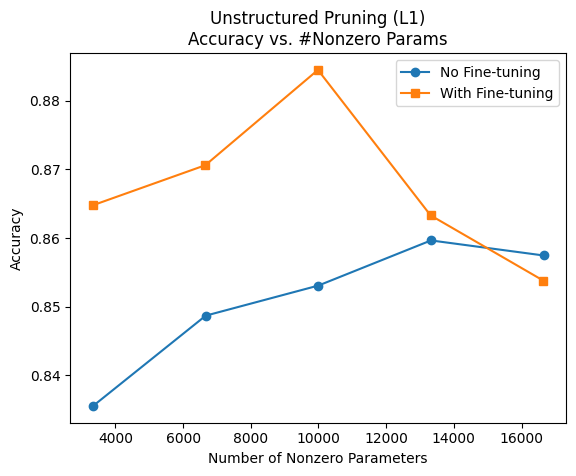

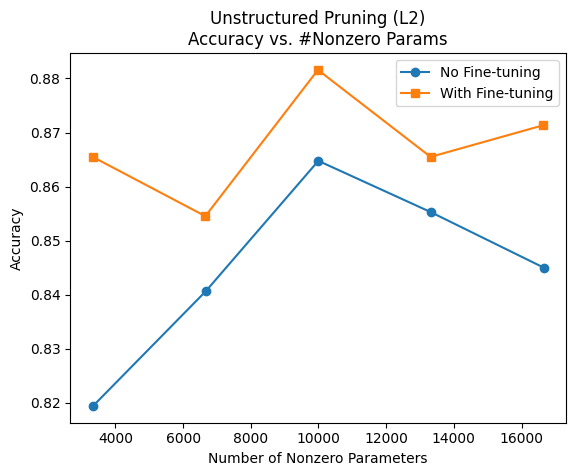

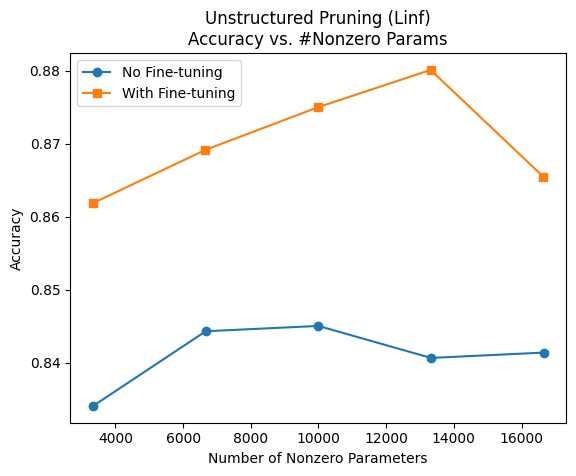

In [15]:
all_results = {}
for reg_type, pretrained_model in zip(['L1', 'L2', 'Linf'], [pretrained_l1, pretrained_l2, pretrained_linf]):
    # Set global model_fp32 to the pretrained model for fair pruning comparison.

    print(f"Running unstructured pruning experiment for model pretrained with {reg_type} regularization:")
    res_no_ft, res_ft = unstructured_pruning_experiment(
        model=pretrained_model,
        pruning_thresholds=[0.0, 0.2, 0.4, 0.6, 0.8],
        train_loader=train_loader,
        val_loader=valid_loader,
        learning_rate=1e-3,
        finetuning_epochs=3
    )
    all_results[reg_type] = (res_no_ft, res_ft)

plot_unstructured_pruning_results(all_results)